# Embedding Birth-Death Processes within a Dynamic Stochastic Block Model (BD-SBM)

This notebook demonstrates how to:

1) Generate or load data (interaction_counts, alive_matrix, birth/death times),

2) Fit the dynamic BD-SBM using Variational EM (VEM) (dense or sparse interactions),

3) Inspect outputs (ELBO, parameter estimates, posterior community memberships, and accuracy).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Optional: silence occasional SciPy fsolve warnings in this notebook output.
import warnings
warnings.filterwarnings(
    "ignore",
    message="The iteration is not making good progress.*",
    category=RuntimeWarning,
)

# 1) Generate or load data

## A) Load data 
Provide:
- **interaction_counts**: array-like of shape *(N, N)* or a `scipy.sparse.spmatrix` of shape *(N, N)*  
  Pairwise interaction counts over the full study interval (symmetric, with a zero diagonal).

- **alive_matrix**: array-like of shape *(N, N)*  
  Pairwise co-aliveness (exposure) matrix: the number of observation times at which individuals *i* and *j* are simultaneously alive/active.

- **df_births_deaths**: `pandas.DataFrame` with at least the columns `['id', 't_birth', 't_death']`  
  Per-individual birth and death times. The `id` values must be consistent with the row/column order of the matrices.


## B) Generate synthetic data
We generate birth/death times and then the aggregated interaction matrices.

### Import the data generation model 

In [2]:
from BDSBM.data_generation import data_generation

### Parameter settings for data generation

In [3]:
lamb = np.array([0.04, 0.04, 0.04, 0.04])   # birth rate per community
mu = np.array([0.02, 0.02, 0.02, 0.02])     # death rate per community
#mu = np.array([0, 0, 0, 0])                # for a pure-birth process (set mu = 0)
t_end = 100                                 # final time (end of the simulation horizon)
L_0 = [[10, 11, 7, 12]]                     # initial number of individuals per community
N_0 = np.sum(L_0)                           # initial number of individuals
K = len(L_0[0])                             # number of communities 
pi_true = np.array([
    [0.75, 0.36, 0.2, 0.16],
    [0.36, 0.91, 0.22, 0.24],
    [0.2, 0.22, 0.82, 0.28],
    [0.16, 0.24, 0.28, 0.66]], dtype=float) # SBM connection probability matrix
snapshots_times = np.arange(0, t_end + 1, 1)# snapshot times at which graphs are generated.

### Run the data-generation step

In [4]:
data = data_generation(lamb, 
                       mu, 
                       t_end, 
                       L_0, 
                       K, 
                       pi_true, 
                       snapshots_times)

In [5]:
interaction_counts, alive_matrix, df_births_deaths = data 

# 2) Fit the dynamic BD-SBM using Variational EM (VEM) (dense or sparse interactions)


You can either **load** the required inputs or **generate** synthetic data using the data-generation utilities.

### Inputs

- **interaction_counts**: array-like of shape *(N, N)* or a `scipy.sparse.spmatrix` of shape *(N, N)*  
  Pairwise interaction counts over the full study interval (symmetric, with a zero diagonal).

- **alive_matrix**: array-like of shape *(N, N)*  
  Pairwise co-aliveness (exposure) matrix: the number of observation times at which individuals *i* and *j* are simultaneously alive/active.

- **df_births_deaths**: `pandas.DataFrame` with at least the columns `['id', 't_birth', 't_death']`  
  Per-individual birth and death times. The `id` values must be consistent with the row/column order of the matrices.

### Initialization

- **delta_init**: array-like of shape *(N, K)* or *(N₀, K)*  
  Initial community-membership probabilities (variational responsibilities).  
  If only *(N₀, K)* is provided, it is interpreted as the initialization for individuals alive at time *t = 0*.

### Outputs

The `fit()` method returns:

`(pi_est, beta_est, lambda_est, mu_est, delta_est, gamma_est, gamma_mar_est, elbo_values, icl, icl_soft_values)`

- **pi_est**: array-like, shape *(K, K)*  
  Estimated SBM connection probability matrix.

- **beta_est**: array-like, shape *(K,)*  
  Estimated community proportions at time *t = 0*.

- **lambda_est**: float  
  Estimated birth rate.

- **mu_est**: float  
  Estimated death rate.

- **delta**: array-like, shape *(N, K)*  
  Estimated community-membership probabilities for all individuals.

- **gamma**: array-like, shape *(T, K, N+1)*  
  Estimated transition probabilities for community sizes along the event timeline.  
  For event index *l*, community *k*, and count *n*, `gamma[l, k, n]` denotes the transition probability to move from *n* to *n* individuals in community *k* at event index *$\ell + 1 $* (time *$\tau_{\ell+1}$*).

- **gamma_mar**: array-like, shape *(T, K, N+1)*  
  Estimated marginal distributions of community sizes over the event timeline.  
  `gamma_mar[l, k, n]` is the probability that, at event index *$\ell$* (time *$\tau_{\ell}$*), there are *n* alive individuals in community *k*.

- **elbo_values**: list or array-like  
  Evidence Lower Bound (ELBO) values across VEM iterations (used to monitor convergence).

- **icl**: float  
  Integrated Completed Likelihood (ICL) criterion.

- **icl_soft_values**: list or array-like  
  Soft/variational version of the ICL criterion across iterations.


### Initialize the variational distribution (delta) for a fixed K

In [6]:
method = 'random' #or 'kmeans'

K_init = 4
N = len(df_births_deaths)
seed = 3

In [7]:
# --- Initialization of delta ---

# Initialization using K-means
if method == 'kmeans':  
    from sklearn.cluster import KMeans
    kmeans_weight = 0.3
    A = (2*interaction_counts-alive_matrix)/alive_matrix
    A[np.isnan(A)] = 0
    kmeans = KMeans(n_clusters=K_init, random_state=seed).fit(A)
    z = kmeans.labels_ 
    Z = np.eye(K)[z].T
    delta_init = kmeans_weight * Z.transpose() + (1 - kmeans_weight)/K

# Random initialization
elif method == 'random':
    rng = np.random.default_rng(seed)
    delta_init = rng.random((N, K_init)) + 1e-3
    delta_init /= delta_init.sum(axis=1, keepdims=True)

### Import the Dynamic BD-SBM VEM model for dense or sparse data

In [8]:
from BDSBM.Dynamic_BDSBM_VEM import DynamicBDSBM_VEM
from BDSBM.Dynamic_BDSBM_VEM_sparse import DynamicBDSBM_VEM_sparse

### Run the BD-SBM VEM model

In [9]:
# Run the model using either a dense or a sparse interaction-count matrix

model_type = 'dense'  # options: 'dense' or 'sparse'

if model_type == 'dense':
    model = DynamicBDSBM_VEM(
        interaction_counts,
        alive_matrix,
        df_births_deaths,
        delta_init,
        max_iters=50,
        tol=1e-10,
    )
    sol = model.fit()

elif model_type == 'sparse':
    model = DynamicBDSBM_VEM_sparse(
        interaction_counts_sparse,
        alive_matrix,
        df_births_deaths,
        delta_init,
        max_iters=50,
        tol=1e-10,
    )
    sol = model.fit()

else:
    raise ValueError("model_type must be either 'dense' or 'sparse'")

pi_est, beta_est, lambda_est, mu_est, delta_est, gamma_est, gamma_mar_est, elbo, icl, icl_soft = sol

## Model selection: choose K via ICL

### Define a grid of candidate K values and random seeds

In [10]:
Ks = range(1, 6)
seeds = range(1,11)
method = 'random' # options: 'kmeans' or 'random'

### Run the model across multiple random seeds and candidate values of K

In [11]:
kmeans_weight = 0.3   # weight for the k-means-based initialization

sol_BDSBM = {}
K_eff = {}
delta_initial = {}

#multiple initializations to avoid local optima
for seed in seeds:
    rng = np.random.default_rng(seed)
    for K in Ks: 
        
        print(f"K={K}, seed={seed}")

        # --- Initialization of delta ---
        if method == 'kmeans':
            kmeans = KMeans(n_clusters=K, random_state=seed).fit(A)
            z = kmeans.labels_ 
            Z = np.eye(K)[z].T
            delta_init = kmeans_weight * Z.transpose() + (1 - kmeans_weight)/K

        elif method == 'random':
            
            delta_init = rng.random((N, K)) + 1e-3
            delta_init /= delta_init.sum(axis=1, keepdims=True)

        delta_initial[K, seed] = delta_init
        
        # --- Fit the model ---    
        model_0 = DynamicBDSBM_VEM(interaction_counts, 
                                   alive_matrix, 
                                   df_births_deaths, 
                                   delta_init, 
                                   max_iters=50, 
                                   tol=1e-10)
        sol_BDSBM[K, seed] = model_0.fit()
        
        pi_est, beta, lambda_est, mu_est, delta, gamma_est, gamma_mar_est, elbo, icl, icl_soft = sol_BDSBM[K, seed]
        
        # --- Compute the effective number of non-empty clusters (MAP assignment) ---       
        idx = np.argmax(delta, axis=1)
        K_effective = np.unique(idx).size
        K_eff[(K, seed)] = K_effective
        

K=1, seed=1
Convergence reached
K=2, seed=1
Convergence reached
K=3, seed=1
Convergence reached
K=4, seed=1
K=5, seed=1
K=1, seed=2
Convergence reached
K=2, seed=2
Convergence reached
K=3, seed=2
Convergence reached
K=4, seed=2
Convergence reached
K=5, seed=2
K=1, seed=3
Convergence reached
K=2, seed=3
Convergence reached
K=3, seed=3
Convergence reached
K=4, seed=3
K=5, seed=3
K=1, seed=4
Convergence reached
K=2, seed=4
Convergence reached
K=3, seed=4
Convergence reached
K=4, seed=4
Convergence reached
K=5, seed=4
K=1, seed=5
Convergence reached
K=2, seed=5
K=3, seed=5
Convergence reached
K=4, seed=5
Convergence reached
K=5, seed=5
K=1, seed=6
Convergence reached
K=2, seed=6
Convergence reached
K=3, seed=6
Convergence reached
K=4, seed=6
K=5, seed=6
K=1, seed=7
Convergence reached
K=2, seed=7
Convergence reached
K=3, seed=7
Convergence reached
K=4, seed=7
K=5, seed=7
K=1, seed=8
Convergence reached
K=2, seed=8
Convergence reached
K=3, seed=8
Convergence reached
K=4, seed=8
K=5, seed=8


### Selection frequency of the effective number of communities (K_eff)

In [12]:
Ks_sorted = sorted(Ks)
best_counts = {K: 0 for K in Ks_sorted}
best_counts_soft = {K: 0 for K in Ks_sorted}

for seed in seeds:
    # Best K according to (hard) ICL for this seed
    best_K = max(Ks_sorted, key=lambda K: sol_BDSBM[(K, seed)][8])

    # Best K according to soft-ICL for this seed
    best_K_soft = max(Ks_sorted, key=lambda K: sol_BDSBM[(K, seed)][9][-1])

    # Count using the effective number of non-empty clusters
    best_counts[K_eff[(best_K, seed)]] += 1
    best_counts_soft[K_eff[(best_K_soft, seed)]] += 1

print("Number of times ICL selected each effective K:")
for K in Ks_sorted:
    print(f"K = {K}: {best_counts[K]} times")

print("Number of times soft-ICL selected each effective K:")
for K in Ks_sorted:
    print(f"K = {K}: {best_counts_soft[K]} times")

Number of times ICL selected each effective K:
K = 1: 0 times
K = 2: 0 times
K = 3: 3 times
K = 4: 7 times
K = 5: 0 times
Number of times soft-ICL selected each effective K:
K = 1: 0 times
K = 2: 0 times
K = 3: 3 times
K = 4: 7 times
K = 5: 0 times


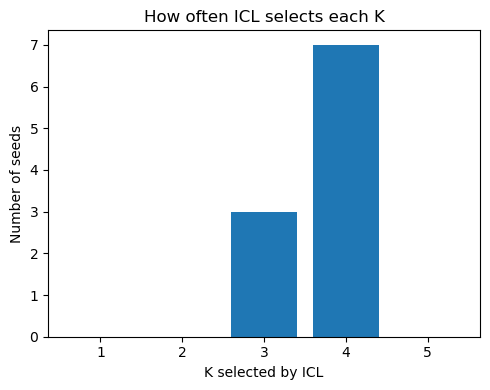

In [13]:
plt.figure(figsize=(5, 4))
plt.bar(list(best_counts.keys()), list(best_counts.values()))
plt.xlabel("K selected by ICL")
plt.ylabel("Number of seeds")
plt.title("How often ICL selects each K")
plt.xticks(Ks_sorted)
plt.tight_layout()
plt.show()

In [14]:
best_k_eff = max(best_counts, key=best_counts.get)
print("Best k_eff (most frequent):", best_k_eff, "with", best_counts[best_k_eff], "seeds")

Best k_eff (most frequent): 4 with 7 seeds


In [15]:
# All (K, seed) pairs whose solution has the desired effective number of clusters
candidates = [(K, seed) for seed in seeds for K in Ks_sorted
              if K_eff[(K, seed)] == best_k_eff]

best_key = max(candidates, key=lambda ks: sol_BDSBM[ks][8])  # index 8 = ICL
K_best, seed_best = best_key

best_sol = sol_BDSBM[best_key]
pi_est, beta_est, lambda_est, mu_est, delta_est, gamma_est, gamma_mar_est, elbo, icl, icl_soft = best_sol

delta_init = delta_initial[best_key]

print(f"Selected solution: K={K_best}, seed={seed_best}, k_eff={best_k_eff}, ICL={icl:.6f}")

if K_best != best_k_eff:
    
    idx = np.argmax(delta_est, axis=1)
    active = np.unique(idx)
    active = np.sort(active)
    
    # --- reduce delta (N x k_eff) and renormalize rows
    delta_red = delta_est[:, active]
    delta_red /= delta_red.sum(axis=1, keepdims=True)
    delta_est = delta_red
    
    # --- reduce beta (k_eff,) and renormalize
    beta_red = beta_est[active]
    beta_red /= beta_red.sum()
    beta_est = beta_red
    
    # --- reduce pi (k_eff x k_eff)
    pi_red = pi_est[np.ix_(active, active)]
    pi_est = pi_red

Selected solution: K=5, seed=6, k_eff=4, ICL=616173.449370


# 3) Inspect outputs (ELBO, parameter estimates, posterior community memberships, and accuracy).


## ELBO evolution

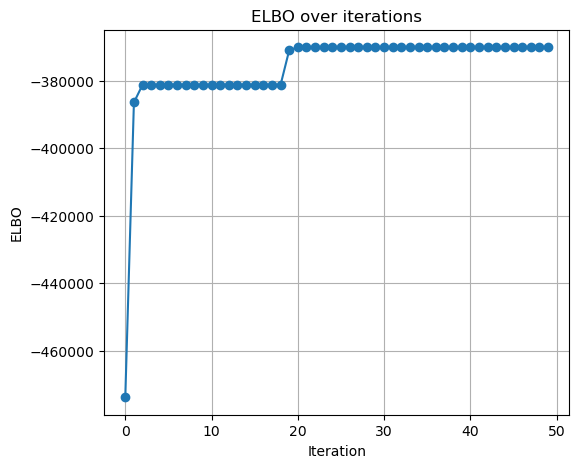

In [16]:
plt.figure(figsize=(6, 5))
plt.plot(elbo, marker='o')
plt.title("ELBO over iterations")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.grid(True)
plt.show()

## Community membership (delta) estimation

In [17]:
true_labels = np.array(df_births_deaths['com'])
pred_labels = np.argmax(delta_est, axis=1)

# Accuracy
acc = accuracy_score(true_labels, pred_labels)
print(f"VEM Accuracy: {acc:.2f}")

VEM Accuracy: 0.00


VEM Accuracy: 1.00


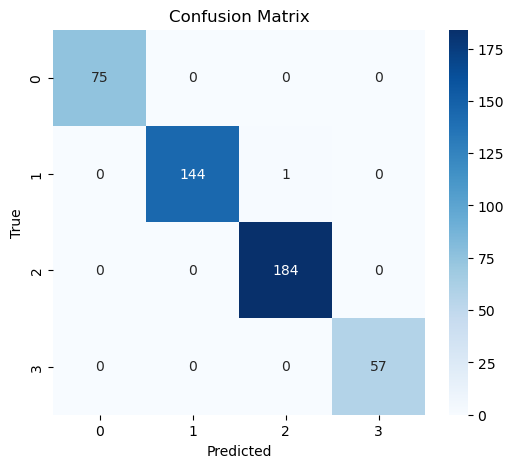

In [18]:
# Find the best label permutation to align predicted labels with the true labels
from scipy.optimize import linear_sum_assignment

# Build the confusion matrix between true and predicted labels
conf_mat = confusion_matrix(true_labels, pred_labels)

# Use the Hungarian algorithm to find the optimal one-to-one label assignment
row_ind, col_ind = linear_sum_assignment(-conf_mat) 

# Build a remapping dictionary: {old_pred_label: aligned_label}
label_map = {col: row for row, col in zip(row_ind, col_ind)}

# Relabel predicted labels according to the optimal assignment
pred_aligned = np.vectorize(label_map.get)(pred_labels)

# Compute accuracy after alignment
acc = accuracy_score(true_labels, pred_aligned)
print(f"VEM Accuracy: {acc:.2f}")

# Confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(true_labels, pred_aligned), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

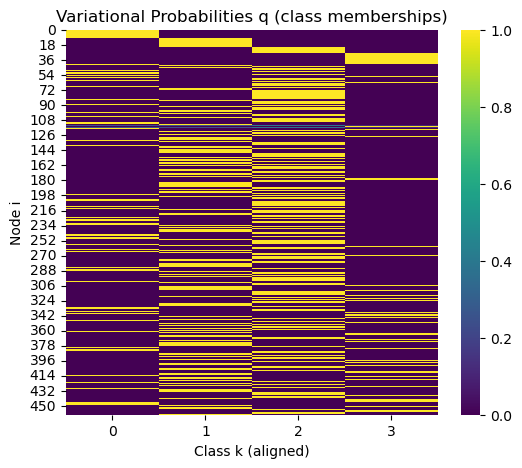

In [19]:
# Build a list defining the new column order (classes)
inverse_label_map = {v: k for k, v in label_map.items()}
new_order = [inverse_label_map[k] for k in range(delta_est.shape[1])]

# Reorder the columns of delta accordingly
delta_aligned = delta_est[:, new_order]

# Posterior probabilities heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(delta_aligned, cmap="viridis")
plt.title("Variational Probabilities q (class memberships)")
plt.xlabel("Class k (aligned)")
plt.ylabel("Node i")
plt.show()

### Parameter estimation $\theta $ = ( $\lambda$, $\mu$, $\pi$, $\beta$)

In [20]:
print(f"True 𝜆:      {lamb[0]:.6f}")
print(f"Estimated 𝜆: {lambda_est:.6f}")
print(f"Absolute error:   {abs(lambda_est - lamb[0]):.6f}")

True 𝜆:      0.040000
Estimated 𝜆: 0.040226
Absolute error:   0.000226


In [21]:
print(f"True 𝜇:      {mu[0]:.6f}")
print(f"Estimated 𝜇: {mu_est:.6f}")
print(f"Absolute error:   {abs(mu_est - mu[0]):.6f}")

True 𝜇:      0.020000
Estimated 𝜇: 0.021785
Absolute error:   0.001785


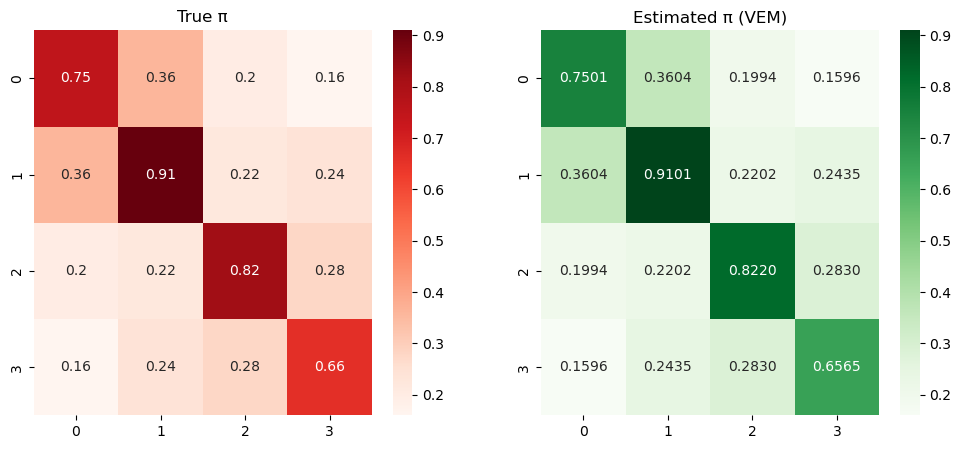

In [22]:
K = pi_est.shape[0]
label_map_inv = {v: k for k, v in label_map.items()}

# Build the permutation vector:
P = np.array([label_map_inv[i] for i in range(K)])

# Reorder the estimated pi matrix to match the aligned class ordering
pi_aligned = pi_est[P][:, P]

# Compare true vs estimated pi
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(pi_true, annot=True, cmap="Reds", ax=axs[0])
axs[0].set_title("True π")
sns.heatmap(pi_aligned, annot=True, cmap="Greens", ax=axs[1], fmt=".4f")
axs[1].set_title("Estimated π (VEM)")
plt.show()

In [23]:
err = pi_aligned - pi_true
print("True π:\n", pi_true)
print("Estimated π:\n", pi_aligned)
print("Abs error:\n", np.abs(err))

True π:
 [[0.75 0.36 0.2  0.16]
 [0.36 0.91 0.22 0.24]
 [0.2  0.22 0.82 0.28]
 [0.16 0.24 0.28 0.66]]
Estimated π:
 [[0.7501396  0.36042049 0.19937155 0.15961141]
 [0.36042049 0.91008966 0.220182   0.24353236]
 [0.19937155 0.220182   0.82195938 0.28298252]
 [0.15961141 0.24353236 0.28298252 0.6564704 ]]
Abs error:
 [[1.39598485e-04 4.20485384e-04 6.28448339e-04 3.88593103e-04]
 [4.20485384e-04 8.96620478e-05 1.81999591e-04 3.53235563e-03]
 [6.28448339e-04 1.81999591e-04 1.95937710e-03 2.98252322e-03]
 [3.88593103e-04 3.53235563e-03 2.98252322e-03 3.52959501e-03]]


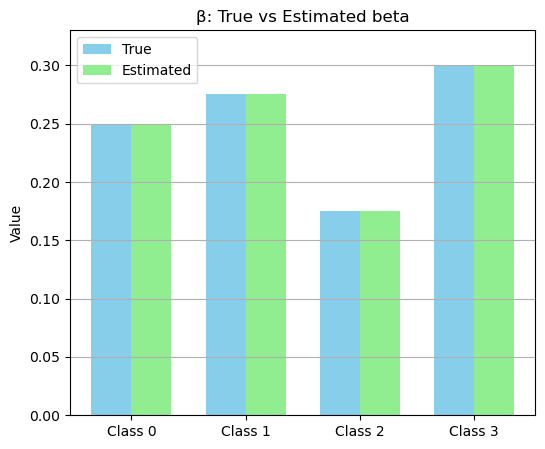

In [24]:
def plot_vector_comparison(true_vec, est_vec, labels=None, title="True vs Estimated Vector"):
    true_vec = np.array(true_vec)
    est_vec = np.array(est_vec[new_order])

    x = np.arange(len(true_vec))
    
    if labels is None:
        labels = [f"Component {i}" for i in label_map[x]]

    width = 0.35
    plt.figure(figsize=(6, 5))
    plt.bar(x - width/2, true_vec, width, label='True', color='skyblue')
    plt.bar(x + width/2, est_vec, width, label='Estimated', color='lightgreen')
    plt.xticks(x, labels)
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.grid(axis='y')
    plt.ylim(0, max(true_vec.max(), est_vec.max()) * 1.1)
    plt.show()
    
beta_true = np.array(L_0).flatten()/np.sum(L_0)
plot_vector_comparison(beta_true, beta_est, labels=[f"Class {k}" for k in range(K)], title="β: True vs Estimated beta")

In [25]:
beta_aligned = beta_est[new_order]
err = beta_aligned - beta_true

print("True β:", np.round(beta_true, 6))
print("Estimated β:", np.round(beta_aligned, 6))
print("Abs error:", np.round(np.abs(err), 6))

True β: [0.25  0.275 0.175 0.3  ]
Estimated β: [0.250004 0.275004 0.175048 0.299944]
Abs error: [4.0e-06 4.0e-06 4.8e-05 5.6e-05]


## Accuracy over time

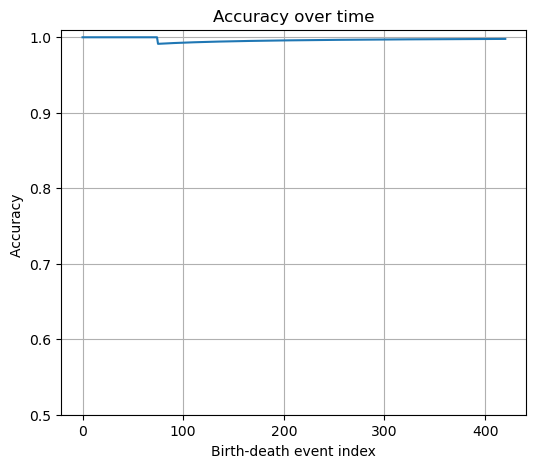

In [26]:
acc_time = []
N_t = []

# Track accuracy as the number of observed/alive nodes changes over time
for t in range(N - N_0):
    
    N_t.append(N_0+t)
    acc_time.append(accuracy_score(true_labels[0:N_0+t], pred_aligned[0:N_0+t]))
    
# Accuracy evolution over birth–death event indices
plt.figure(figsize=(6, 5))
plt.plot(acc_time, marker='')
plt.title("Accuracy over time")
plt.xlabel("Birth-death event index")
plt.ylabel("Accuracy ")
plt.ylim(0.5, 1.01)
plt.grid(True)
plt.show()    

### Comparison with the initialization

VEM Accuracy: 0.24


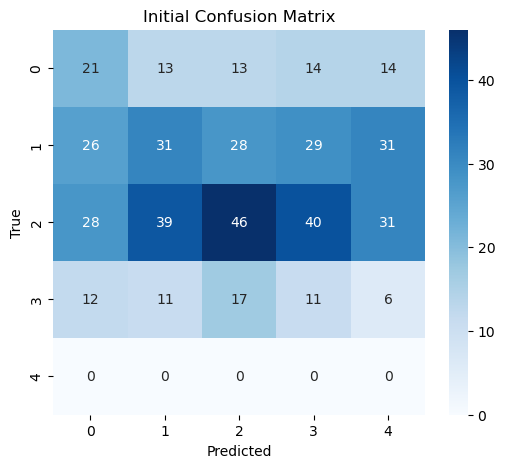

In [27]:
# Find the best label permutation to align initialization labels with the true labels
pred_labels_init = np.argmax(delta_init, axis=1)

# Build the confusion matrix between true and predicted labels
conf_mat_init = confusion_matrix(true_labels, pred_labels_init)

# Use the Hungarian algorithm to find the optimal one-to-one label assignment
row_ind, col_ind = linear_sum_assignment(-conf_mat_init) 

# Build a remapping dictionary: {old_pred_label: aligned_label}
label_map_init = {col: row for row, col in zip(row_ind, col_ind)}

# Relabel predicted labels according to the optimal assignment
pred_aligned_init = np.vectorize(label_map_init.get)(pred_labels_init)

# Compute accuracy after alignment
acc = accuracy_score(true_labels, pred_aligned_init)
print(f"VEM Accuracy: {acc:.2f}")

# Confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(true_labels, pred_aligned_init), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Initial Confusion Matrix")
plt.show()

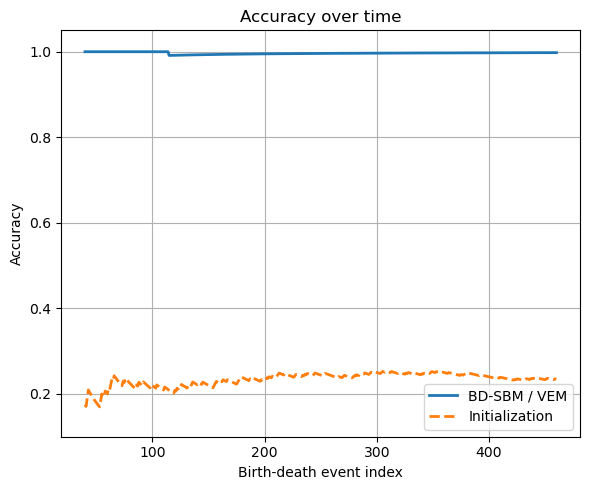

In [28]:
acc_time = []
acc_time_init = []
N_t = []

for t in range(N - N_0):
    
    N_t.append(N_0+t)
    acc_time.append(accuracy_score(true_labels[0:N_0+t], pred_aligned[0:N_0+t]))
    acc_time_init.append(accuracy_score(true_labels[0:N_0+t], pred_aligned_init[0:N_0+t]))

# Accuracy evolution over birth–death event indices
plt.figure(figsize=(6, 5))
plt.plot(N_t, acc_time, label="BD-SBM / VEM", linewidth=2)
plt.plot(N_t, acc_time_init, label="Initialization", linewidth=2, linestyle="--")
plt.title("Accuracy over time")
plt.xlabel("Birth-death event index")
plt.ylabel("Accuracy")
plt.ylim(0.1, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()    